[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana1/2_LDA_Clasificacion_Default.ipynb)


# Intro a Pandas

Solo veremos como crear un DataFrame básico, asi como la diferencia entre una Series y un DataFrame. Con los datos reales utilizaremos otros métodos de Pandas.

Modo 1:

In [ ]:
import pandas

In [ ]:
pandas.DataFrame([[1,2,3], [4,5,6]])

,0,1,2
0,1,2,3
1,4,5,6


In [ ]:
from pandas import DataFrame

In [ ]:
DataFrame([[1,2,3], [4,5,6]])

,0,1,2
0,1,2,3
1,4,5,6


In [ ]:
from pandas import *

In [ ]:
DataFrame([[1,2,3], [4,5,6]])

,0,1,2
0,1,2,3
1,4,5,6


In [ ]:
import pandas as pd

In [ ]:
df_basico = pd.DataFrame([[1,2,3], [4,5,6]])
df_basico

,0,1,2
0,1,2,3
1,4,5,6


In [ ]:
df_basico = pd.DataFrame([[1,2,3], [4,5,6]], index=['fila_1', 'fila_2'], columns=['col_1', 'col_2', 'col_3'])
df_basico

,col_1,col_2,col_3
fila_1,1,2,3
fila_2,4,5,6


In [ ]:
df_basico = pd.DataFrame({'c_1' : [1, 4], 'c_2': [2, 5], 'c_3': [3, 6]})
df_basico

,c_1,c_2,c_3
0,1,2,3
1,4,5,6


## Diferencia entre atributo y método (POO)

In [ ]:
# Use la función "len" para ver el tamaño del DataFrame
len(df_basico)

2

In [ ]:
# Use el método "sum" en el DataFrame
df_basico.sum(axis=1)

0     6
1    15
dtype: int64

In [ ]:
# El DataFrame tiene un atributo llamado "columns", lo que nos dice las columnas que tiene nuestra tabla, ¿Sabes como usarlo?
df_basico.columns

Index(['c_1', 'c_2', 'c_3'], dtype='object')

# Enlace al drive del profesor:
https://drive.google.com/drive/folders/1x3DAC_UP4HY33ud5iuMoO4N4A8Y1V6ui?usp=sharing


#Objetivo

En este notebook veremos todos los pasos necesarios para aplicar clasificar si una persona entrará en default (no pagará) un préstamo.

Que un individuo (o empresa, asociación, etc.) entre en **default** quiere decir que falló en pagar su deuda. Predecir a los individuos con mayor probabilidad de entrar en este estado, ayuda a planear estrategias sobre las inversiones que se realizarán (préstamos en este caso).

Para clasificar, usaremos Linear Discriminant Analysis (LDA).

Estos pasos comprenden:

1. Obtención de los datos
2. Limpieza y preparación de los datos
    1. Valores nulos
    2. Tipos de variables
    3. Variables con poca variación
    4. Variables con alta correlación
    5. Creación de variables dummy
    6. Imputación de datos faltantes
3. Entrenamiento y evaluación del modelo obtenido con LDA.



El propósito de la limpieza y preparación de los datos, es conseguir un DataFrame (o matriz) que podamos usar en el algoritmo.



# Dependencias

In [ ]:
!pip install -U plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 34.0 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.15.0
    Uninstalling plotly-5.15.0:
      Successfully uninstalled plotly-5.15.0


In [ ]:
from pprint import pprint

import numpy as np

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix

import plotly.express as px

# Datos

Trabajaremos con datos del Lending Club.

Lending Club es una plataforma de préstamos entre pares (P2P), donde los prestatarios envían sus solicitudes de préstamo y los prestamistas individuales seleccionan las solicitudes que desean financiar. Los prestatarios reciben el monto total del préstamo emitido menos la tarifa inicial, que se paga a la empresa. Los inversores compran notas respaldadas por préstamos personales y pagan a Lending Club una tarifa de servicio.

Los préstamos P2P reducen el costo de los préstamos personales en comparación con el financiamiento tradicional al conectar directamente a los prestatarios e inversores. Sin embargo, siempre existe el riesgo de invertir en un préstamo incobrable. De hecho, la tasa de incumplimiento de los préstamos P2P es mucho más alta que la de los préstamos tradicionales. Por lo tanto, la industria crediticia está muy interesada en brindar a los inversionistas una evaluación integral del riesgo de las solicitudes de préstamo. La empresa comparte datos sobre todas las solicitudes de préstamos realizadas a través de su plataforma.

La descripción de las variables en el dataset se puede descargar [aqui](https://www-2.rotman.utoronto.ca/~hull/MLThirdEditionFiles/LendingClubLogisticRegression/lendingclub_datadictionary.xlsx).


## Descarga de los datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
sep = "\n-------------------\n"

In [ ]:
info_etiquetas = pd.read_excel('/content/drive/MyDrive/Cruso-ApsFinancieras/semana1/lendingclub_datadictionary.xlsx', index_col=0)

In [ ]:
info_etiquetas

,Description
column_name,
id,A unique LC assigned ID for the loan listing.
member_id,A unique LC assigned Id for the borrower member.
loan_amnt,The listed amount of the loan applied for by t...
term,The number of payments on the loan. Values are...
int_rate,Interest Rate on the loan
...,...
settlement_status,The status of the borrower’s settlement plan. ...
settlement_date,The date that the borrower agrees to the settl...
settlement_amount,The loan amount that the borrower has agreed t...


In [ ]:
info_etiquetas.loc['hardship_loan_status',:]

Description    Loan Status as of the hardship plan start date
Name: hardship_loan_status, dtype: object

## Lectura de los datos

In [ ]:
data_raw = pd.read_excel("/content/drive/MyDrive/Cruso-ApsFinancieras/semana1/lending_clubFull_Data_Set.xlsx", index_col=0)
data_raw

,id,member_id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,263591,545710,20000.0,60 months,17.93,342.94,E,E5,Wylie ISD,1 year,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN
1,1613916,69664096,30000.0,36 months,11.99,996.29,C,C1,Sergeant,10+ years,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN
2,818934,8965180,21500.0,36 months,11.99,714.01,B,B3,Designer,1 year,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN
3,1606612,70572960,10000.0,36 months,13.67,340.18,C,C3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN
4,1639932,68589517,5000.0,36 months,8.49,157.82,B,B1,Sr. Manufacturing Engineer,10+ years,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,901888,4974773,10500.0,36 months,10.16,339.60,B,B1,Schneider Electric,5 years,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN
24996,945413,1279809,12000.0,36 months,14.33,412.06,C,C1,Clark County School District,10+ years,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN
24997,366944,63496281,25000.0,36 months,12.69,838.63,C,C2,sales consultant,< 1 year,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN
24998,1043529,98124387,12200.0,60 months,13.49,280.66,C,C2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaT,NaN,NaT,NaN,NaN,NaN


## Datos Faltantes

In [ ]:
data_raw.isna().sum().sort_values()

id                                                0
member_id                                         0
initial_list_status                               1
last_fico_range_low                               1
revol_bal                                         1
                                              ...  
hardship_status                               24904
hardship_reason                               24904
hardship_type                                 24904
deferral_term                                 24904
orig_projected_additional_accrued_interest    24920
Length: 134, dtype: int64

In [ ]:
na_values = (data_raw.isna().sum().sort_values() / len(data_raw)).reset_index(name = 'n')
na_values

,index,n
0,id,0.00000
1,member_id,0.00000
2,initial_list_status,0.00004
3,last_fico_range_low,0.00004
4,revol_bal,0.00004
...,...,...
129,hardship_status,0.99616
130,hardship_reason,0.99616
131,hardship_type,0.99616
132,deferral_term,0.99616


In [ ]:
aux = na_values[na_values['n']>0.1]

In [ ]:
aux

,index,n
76,mths_since_recent_inq,0.13516
77,next_pymnt_d,0.49164
78,mths_since_last_delinq,0.49172
79,open_acc_6m,0.52096
80,open_act_il,0.52096
81,inq_last_12m,0.52096
82,open_il_12m,0.52096
83,open_il_24m,0.52096
84,total_bal_il,0.52096
85,open_rv_24m,0.52096


In [ ]:
columns_to_drop = list(aux['index'])

In [ ]:
columns_to_drop

['mths_since_recent_inq',
 'next_pymnt_d',
 'mths_since_last_delinq',
 'open_acc_6m',
 'open_act_il',
 'inq_last_12m',
 'open_il_12m',
 'open_il_24m',
 'total_bal_il',
 'open_rv_24m',
 'max_bal_bc',
 'inq_fi',
 'total_cu_tl',
 'open_rv_12m',
 'all_util',
 'mths_since_rcnt_il',
 'il_util',
 'mths_since_recent_revol_delinq',
 'mths_since_last_major_derog',
 'mths_since_recent_bc_dlq',
 'mths_since_last_record',
 'desc',
 'dti_joint',
 'verification_status_joint',
 'annual_inc_joint',
 'sec_app_open_act_il',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_num_rev_accts',
 'sec_app_open_acc',
 'sec_app_fico_range_high',
 'sec_app_inq_last_6mths',
 'sec_app_earliest_cr_line',
 'sec_app_fico_range_low',
 'revol_bal_joint',
 'sec_app_mort_acc',
 'sec_app_revol_util',
 'settlement_amount',
 'settlement_status',
 'settlement_date',
 'debt_settlement_flag_date',
 'settlement_percentage',
 'settlement_term',
 'sec_app_mths_since_last_major_derog',
 'hardship_

In [ ]:
len(columns_to_drop)

58

In [ ]:
px.bar(na_values, "index", "n")

In [ ]:
data_filt = data_raw.drop(columns=columns_to_drop)
data_filt

,id,member_id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag
0,263591,545710,20000.0,60 months,17.93,342.94,E,E5,Wylie ISD,1 year,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N
1,1613916,69664096,30000.0,36 months,11.99,996.29,C,C1,Sergeant,10+ years,...,1.0,90.0,25.0,1.0,0.0,116075.0,69594.0,27500.0,83175.0,N
2,818934,8965180,21500.0,36 months,11.99,714.01,B,B3,Designer,1 year,...,1.0,100.0,50.0,0.0,0.0,116920.0,74939.0,19700.0,78020.0,N
3,1606612,70572960,10000.0,36 months,13.67,340.18,C,C3,NaN,NaN,...,3.0,80.0,50.0,0.0,0.0,39547.0,16824.0,11200.0,25547.0,N
4,1639932,68589517,5000.0,36 months,8.49,157.82,B,B1,Sr. Manufacturing Engineer,10+ years,...,0.0,60.0,100.0,0.0,0.0,104310.0,7582.0,3300.0,13015.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,901888,4974773,10500.0,36 months,10.16,339.60,B,B1,Schneider Electric,5 years,...,1.0,96.0,25.0,0.0,0.0,263503.0,40380.0,13000.0,33279.0,N
24996,945413,1279809,12000.0,36 months,14.33,412.06,C,C1,Clark County School District,10+ years,...,3.0,100.0,40.0,0.0,0.0,64327.0,64497.0,5400.0,51027.0,N
24997,366944,63496281,25000.0,36 months,12.69,838.63,C,C2,sales consultant,< 1 year,...,1.0,90.2,33.3,0.0,0.0,183700.0,22014.0,3600.0,0.0,N
24998,1043529,98124387,12200.0,60 months,13.49,280.66,C,C2,NaN,NaN,...,2.0,100.0,33.3,0.0,0.0,22500.0,13615.0,20000.0,1000.0,N


In [ ]:
print("Datos originales\n")
print(data_raw.dtypes.value_counts())
print(sep)
print("Datos filtrado\n")
data_filt.dtypes.value_counts()

Datos originales

float64           100
object             24
datetime64[ns]      9
int64               1
Name: count, dtype: int64

-------------------

Datos filtrado



float64           56
object            17
datetime64[ns]     2
int64              1
Name: count, dtype: int64

In [ ]:
data_filt.columns

Index(['id', 'member_id', 'loan_amnt', 'term', 'int_rate', 'installment',
       'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership',
       'annual_inc', 'verification_status', 'loan_status', 'pymnt_plan',
       'purpose', 'title', 'zip_code', 'addr_state', 'dti', 'delinq_2yrs',
       'earliest_cr_line', 'fico_range_low', 'fico_range_high',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'last_credit_pull_d',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'num_accts_ever_120_pd',
       'n

## Parentesis culturales

In [ ]:
df_basico

,c_1,c_2,c_3
0,1,2,3
1,4,5,6


Diferencia entre Series y DataFrame

In [ ]:
# Series
df_basico['c_2']

0    2
1    5
Name: c_2, dtype: int64

In [ ]:
df_basico['c_2'].shape

(2,)

In [ ]:
# DataFrame
df_basico[['c_2']]

,c_2
0,2
1,5


In [ ]:
df_basico[['c_2']].shape

(2, 1)

## Fin del paréntesis cultural

Veamos los tipos de estatus para un préstamo

In [ ]:
data_filt['loan_status']

0               Charged Off
1                   Current
2                Fully Paid
3                Fully Paid
4                   Current
                ...        
24995            Fully Paid
24996            Fully Paid
24997    Late (31-120 days)
24998               Current
24999               Current
Name: loan_status, Length: 25000, dtype: object

In [ ]:
data_filt['loan_status'].value_counts(dropna = False)

loan_status
Current                                                12063
Fully Paid                                              9733
Charged Off                                             2557
Late (31-120 days)                                       336
In Grace Period                                          174
Late (16-30 days)                                        101
Does not meet the credit policy. Status:Fully Paid        28
Does not meet the credit policy. Status:Charged Off        5
Default                                                    2
NaN                                                        1
Name: count, dtype: int64

In [ ]:
loan_status_to_objective = {
    "Current": 0,
    "Fully Paid": 0,
    "Charged Off": 1,
    "Late (31-120 days)": 0,
    "In Grace Period": 0,
    "Late (16-30 days)": 0,
    "Default": 1,
}

X = data_filt.drop(columns=['loan_status'], axis=1)

# Utilizamos el mapeo definido en el diccionario de arriba

y = data_filt['loan_status'].map(loan_status_to_objective)
#y = data_filt.loan_status.map(loan_status_to_objective)

# Quedarme con las que no tienen valor nulo en la variable objetivo
X = X[~y.isna()]
y = y[~y.isna()]
print(X.shape, y.shape)
y.dtype

(24966, 75) (24966,)


dtype('float64')

In [ ]:
X

,id,member_id,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,...,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag
0,263591,545710,20000.0,60 months,17.93,342.94,E,E5,Wylie ISD,1 year,...,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,N
1,1613916,69664096,30000.0,36 months,11.99,996.29,C,C1,Sergeant,10+ years,...,1.0,90.0,25.0,1.0,0.0,116075.0,69594.0,27500.0,83175.0,N
2,818934,8965180,21500.0,36 months,11.99,714.01,B,B3,Designer,1 year,...,1.0,100.0,50.0,0.0,0.0,116920.0,74939.0,19700.0,78020.0,N
3,1606612,70572960,10000.0,36 months,13.67,340.18,C,C3,NaN,NaN,...,3.0,80.0,50.0,0.0,0.0,39547.0,16824.0,11200.0,25547.0,N
4,1639932,68589517,5000.0,36 months,8.49,157.82,B,B1,Sr. Manufacturing Engineer,10+ years,...,0.0,60.0,100.0,0.0,0.0,104310.0,7582.0,3300.0,13015.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,901888,4974773,10500.0,36 months,10.16,339.60,B,B1,Schneider Electric,5 years,...,1.0,96.0,25.0,0.0,0.0,263503.0,40380.0,13000.0,33279.0,N
24996,945413,1279809,12000.0,36 months,14.33,412.06,C,C1,Clark County School District,10+ years,...,3.0,100.0,40.0,0.0,0.0,64327.0,64497.0,5400.0,51027.0,N
24997,366944,63496281,25000.0,36 months,12.69,838.63,C,C2,sales consultant,< 1 year,...,1.0,90.2,33.3,0.0,0.0,183700.0,22014.0,3600.0,0.0,N
24998,1043529,98124387,12200.0,60 months,13.49,280.66,C,C2,NaN,NaN,...,2.0,100.0,33.3,0.0,0.0,22500.0,13615.0,20000.0,1000.0,N


In [ ]:
y

0        1.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
24995    0.0
24996    0.0
24997    0.0
24998    0.0
24999    0.0
Name: loan_status, Length: 24966, dtype: float64

In [ ]:
data_filt['loan_amnt']

0        20000.0
1        30000.0
2        21500.0
3        10000.0
4         5000.0
          ...   
24995    10500.0
24996    12000.0
24997    25000.0
24998    12200.0
24999     5000.0
Name: loan_amnt, Length: 25000, dtype: float64

In [ ]:
data_filt.loan_amnt

0        20000.0
1        30000.0
2        21500.0
3        10000.0
4         5000.0
          ...   
24995    10500.0
24996    12000.0
24997    25000.0
24998    12200.0
24999     5000.0
Name: loan_amnt, Length: 25000, dtype: float64

In [ ]:
y.value_counts()

loan_status
0.0    22407
1.0     2559
Name: count, dtype: int64

# Análisis de las variables por tipo

In [ ]:
X.dtypes.unique()

array([dtype('int64'), dtype('O'), dtype('float64'), dtype('<M8[ns]')],
      dtype=object)

In [ ]:
# En el código siguiente, ¿donde se utiliza un método y donde un atributo? ¿Se utiliza alguna función?

columns_by_type = {
    'datetime[ns]': X.select_dtypes('<M8[ns]').columns,
    'float64':      X.select_dtypes('float64').columns,
    'int64':        X.select_dtypes('int64').columns,
    'object':       X.select_dtypes('object').columns
}
pprint(columns_by_type)

{'datetime[ns]': Index(['earliest_cr_line', 'last_credit_pull_d'], dtype='object'),
 'float64': Index(['loan_amnt', 'int_rate', 'installment', 'annual_inc', 'dti',
       'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'num_accts_ever_120_pd',
       'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl',
       'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0',
       'num_sats', 'num_tl_120dpd_2m', 'num_tl_30dpd', 'num_tl_90g_dp

## Variables Numéricas


## Recordemos las dependencias importadas

- from sklearn.preprocessing import StandardScaler, MinMaxScaler
- from sklearn.model_selection import train_test_split
- from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
- from sklearn.metrics import classification_report, confusion_matrix

 Instanciaremos un objeto de clase "StandardScaler"

In [ ]:
scaler = StandardScaler()
print(type(scaler))

<class 'sklearn.preprocessing._data.StandardScaler'>


Utilizaremos dicho objeto

In [ ]:
scaler.fit_transform(X[columns_by_type['float64']])

array([[ 0.60531698,  0.99365293, -0.36740105, ...,         nan,
                nan,         nan],
       [ 1.74644502, -0.25866596,  2.18486486, ...,  0.39301852,
         0.25836034,  0.91303435],
       [ 0.77648619, -0.25866596,  1.08215786, ...,  0.50534279,
        -0.09985894,  0.79550136],
       ...,
       [ 1.175881  , -0.11108629,  1.56897714, ..., -0.60686715,
        -0.83926028, -0.98333937],
       [-0.28476289,  0.05757619, -0.61069349, ..., -0.78337071,
        -0.08608128, -0.96053957],
       [-1.10637508,  1.22556384, -0.99078911, ...,  0.1866949 ,
        -0.75200174,  0.34454403]])

In [ ]:
scaler = StandardScaler()
data_num_sc = pd.DataFrame(scaler.fit_transform(X[columns_by_type['float64']]), columns = X[columns_by_type['float64']].columns, index = X[columns_by_type['float64']].index)
data_num_sc

,loan_amnt,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,0.605317,0.993653,-0.367401,-0.596320,-0.010158,-0.371036,-0.179070,-0.179072,-0.670214,-1.023591,...,NaN,NaN,NaN,NaN,-0.354315,-0.150416,NaN,NaN,NaN,NaN
1,1.746445,-0.258666,2.184865,1.071667,0.143614,2.924724,-0.818995,-0.818968,0.425710,0.062645,...,1.717029,-0.601370,-0.424478,-0.581503,2.256547,-0.150416,-0.338577,0.393019,0.258360,0.913034
2,0.776486,-0.258666,1.082158,-0.492707,0.783621,-0.371036,1.260759,1.260696,0.425710,0.243684,...,-0.174699,-0.601370,0.679972,0.112846,-0.354315,-0.150416,-0.333818,0.505343,-0.099859,0.795501
3,-0.535811,0.095525,-0.378183,-0.230765,-0.137590,2.924724,-0.659013,-0.658994,-0.670214,-0.480473,...,-0.174699,0.503440,-1.528929,0.112846,-0.354315,-0.150416,-0.769582,-0.715934,-0.490226,-0.400873
4,-1.106375,-0.996564,-1.090559,0.198528,-0.946320,-0.371036,-1.138957,-1.138917,-0.670214,-1.385669,...,-0.174699,-1.153775,-3.737829,1.501543,-0.354315,-0.150416,-0.404837,-0.910153,-0.853038,-0.686600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,-0.478755,-0.644481,-0.380449,0.016624,-0.643046,-0.371036,-0.339051,-0.339046,0.425710,-0.118394,...,-0.174699,-0.601370,0.238192,-0.581503,-0.354315,-0.150416,0.491736,-0.220909,-0.407560,-0.224585
24996,-0.307585,0.234672,-0.097389,0.089385,-0.488562,-0.371036,-0.179070,-0.179072,0.425710,0.243684,...,-0.174699,0.503440,0.679972,-0.164894,-0.354315,-0.150416,-0.630021,0.285906,-0.756594,0.180066
24997,1.175881,-0.111086,1.568977,-0.310803,-0.375368,0.727551,-0.978976,-0.978942,0.425710,0.062645,...,-0.174699,-0.601370,-0.402389,-0.350979,-0.354315,-0.150416,0.042286,-0.606867,-0.839260,-0.983339
24998,-0.284763,0.057576,-0.610693,-0.594573,-0.571144,-0.371036,-0.019089,-0.019097,-0.670214,-1.204630,...,-0.174699,-0.048965,0.679972,-0.350979,-0.354315,-0.150416,-0.865590,-0.783371,-0.086081,-0.960540


### Variables con alta correlación

La **correlación** es una médida estadística que muestra la relación, ya sea causal o no, entre dos variables. La médida más usada es el **Coeficiente de Correlación de Pearson**. Para dos variables $X = (x_1, x_2, \dots, x_n)$ y $Y = (y_1, y_2, \dots, y_n)$,

$$\rho_{X, Y} = corr(X, Y) = \frac{cov(X, Y)}{\sigma_{X}\sigma_{Y}}$$

en donde $\sigma_{X}$ es la desviación estándar de $X$ y $$cov(X, Y) = \frac{1}{n-1}\sum_{i=1}^{n}(x_i - \mu_x)(y_i-\mu_y)$$
con $\mu_x$ la media de $X$.



https://www.maximaformacion.es/blog-dat/que-es-la-correlacion-estadistica-y-como-interpretarla/

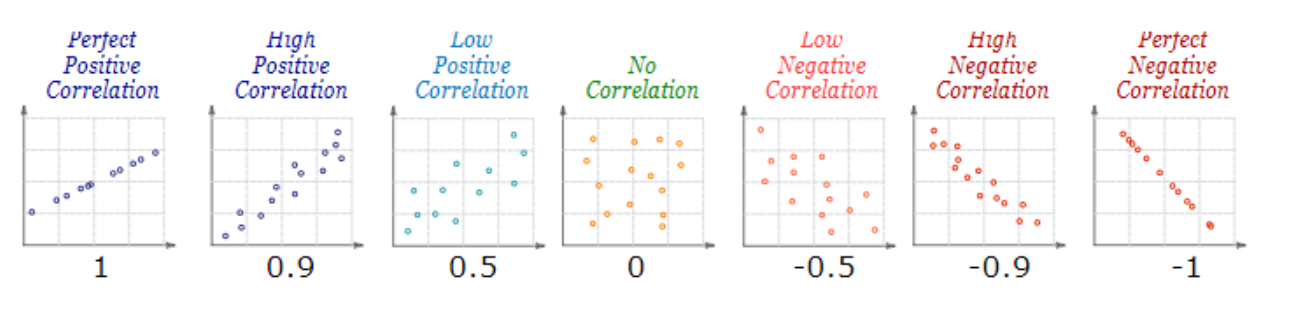

In [ ]:
numeric_to_remove = []

In [ ]:
corr_df = data_num_sc.corr()
px.imshow(corr_df,
          labels=dict(color="Correlación"),
          x=corr_df.index,
          y=corr_df.columns,
          range_color=[-1, 1],
          color_continuous_scale="oxy"
          )


¿Que pasa si hacemos la matriz de correlaciones sin reescalar los datos?

In [ ]:
# corr_df = X_train[columns_by_type['float64']].corr() # NOTA: matriz de correlación con los datos sin escalar

In [ ]:
correlated_features = set()
for i in range(len(corr_df.columns)):
    for j in range(i):
        if abs(corr_df.iloc[i, j]) > 0.7:
            colname = corr_df.columns[i]
            correlated_features.add(colname)
len(correlated_features)

20

In [ ]:
correlated_features

{'avg_cur_bal',
 'bc_util',
 'fico_range_high',
 'installment',
 'last_fico_range_low',
 'num_actv_rev_tl',
 'num_bc_sats',
 'num_bc_tl',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_30dpd',
 'num_tl_op_past_12m',
 'percent_bc_gt_75',
 'tot_hi_cred_lim',
 'total_acc',
 'total_bc_limit',
 'total_il_high_credit_limit',
 'total_rev_hi_lim'}

In [ ]:
X.drop(columns=correlated_features, inplace=True)

data_num_sc.drop(columns=correlated_features, inplace=True)
columns_by_type['float64'] = columns_by_type['float64'].drop(correlated_features)

In [ ]:
X

,id,member_id,loan_amnt,term,int_rate,grade,sub_grade,emp_title,emp_length,home_ownership,...,num_accts_ever_120_pd,num_actv_bc_tl,num_il_tl,num_tl_120dpd_2m,num_tl_90g_dpd_24m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,hardship_flag
0,263591,545710,20000.0,60 months,17.93,E,E5,Wylie ISD,1 year,MORTGAGE,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,N
1,1613916,69664096,30000.0,36 months,11.99,C,C1,Sergeant,10+ years,MORTGAGE,...,1.0,3.0,12.0,0.0,1.0,90.0,1.0,0.0,69594.0,N
2,818934,8965180,21500.0,36 months,11.99,B,B3,Designer,1 year,RENT,...,0.0,3.0,15.0,0.0,0.0,100.0,0.0,0.0,74939.0,N
3,1606612,70572960,10000.0,36 months,13.67,C,C3,NaN,NaN,RENT,...,0.0,3.0,2.0,0.0,0.0,80.0,0.0,0.0,16824.0,N
4,1639932,68589517,5000.0,36 months,8.49,B,B1,Sr. Manufacturing Engineer,10+ years,MORTGAGE,...,1.0,1.0,1.0,0.0,0.0,60.0,0.0,0.0,7582.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,901888,4974773,10500.0,36 months,10.16,B,B1,Schneider Electric,5 years,MORTGAGE,...,0.0,4.0,11.0,0.0,0.0,96.0,0.0,0.0,40380.0,N
24996,945413,1279809,12000.0,36 months,14.33,C,C1,Clark County School District,10+ years,RENT,...,0.0,3.0,9.0,0.0,0.0,100.0,0.0,0.0,64497.0,N
24997,366944,63496281,25000.0,36 months,12.69,C,C2,sales consultant,< 1 year,MORTGAGE,...,0.0,2.0,24.0,0.0,0.0,90.2,0.0,0.0,22014.0,N
24998,1043529,98124387,12200.0,60 months,13.49,C,C2,NaN,NaN,OWN,...,0.0,2.0,9.0,0.0,0.0,100.0,0.0,0.0,13615.0,N



## Fechas

Las fechas no las ocuparemos a menos en este análisis. Aunque cabe destacar que podrían ocupar si se transforman a otro tipo de dato (e.g. crear "número de días desde..." y obtener la nueva variable usando una diferencia en días entre fechas).

In [ ]:
for col in columns_by_type["datetime[ns]"]:
    print(data_filt[col].head(), sep)

0   1995-11-01
1   2003-10-01
2   1999-10-01
3   1983-11-01
4   2000-04-01
Name: earliest_cr_line, dtype: datetime64[ns] 
-------------------

0   2016-10-01
1   2017-12-01
2   2017-03-01
3   2017-12-01
4   2017-12-01
Name: last_credit_pull_d, dtype: datetime64[ns] 
-------------------



In [ ]:
X.drop(columns=columns_by_type["datetime[ns]"], inplace=True)

## Factores (OneHotEncoding o Dummificacion)

Para poder usar factores en el modelo, es mecesario convertirlas a variables dummies. Esto es, considerando la siguiente variable:

estado_civil|
------------|
soltero
casado
soltero
soltero
viudo

Al obtener las variables dummies de esta obtendriamos:

estado_civil_soltero|estado_civil_casado|estado_civil_viudo
---|---|---
1|0|0
0|1|0
1|0|0
1|0|0
0|0|1

Incluso se puede quitar uno de los niveles y dejarlo como el estado base:

estado_civil_casado|estado_civil_viudo
---|---
0|0
1|0
0|0
0|0
0|1


Si nuestra variable tiene muchos niveles, el crear variables dummies de esta puede hacer que nuestro dataset crezca en dimensión, complicando el entrenamiento del modelo. Para estos casos, se puede buscar la posibilidad de unir distintos niveles en uno sólo o eliminar la variable.

"una columna de N categorias en N-1 columnas binarias"

In [ ]:
unique_values_by_column = X[columns_by_type["object"]].nunique().reset_index(name = "n")
unique_values_by_column

,index,n
0,member_id,24966
1,term,2
2,grade,7
3,sub_grade,35
4,emp_title,13212
5,emp_length,11
6,home_ownership,6
7,verification_status,3
8,pymnt_plan,2
9,purpose,14


In [ ]:
px.bar(data_frame = unique_values_by_column,
       x ="index",
       y = "n",
       title="Cantidad de niveles por factor",
       labels={
           "index": "Nombre de la variable",
           "n": "Número de niveles"
           }
       )

Eliminamos las variables con más de 900 niveles.

In [ ]:
drop_columns = columns_by_type["object"][unique_values_by_column.n > 800].to_list()
drop_columns

['member_id', 'emp_title', 'title', 'zip_code']

In [ ]:
X.drop(columns=drop_columns, inplace=True)

columns_by_type['object'] = columns_by_type['object'].drop(drop_columns)

In [ ]:
X

,id,loan_amnt,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,...,num_accts_ever_120_pd,num_actv_bc_tl,num_il_tl,num_tl_120dpd_2m,num_tl_90g_dpd_24m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_bal_ex_mort,hardship_flag
0,263591,20000.0,60 months,17.93,E,E5,1 year,MORTGAGE,44304.0,Verified,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,N
1,1613916,30000.0,36 months,11.99,C,C1,10+ years,MORTGAGE,136000.0,Verified,...,1.0,3.0,12.0,0.0,1.0,90.0,1.0,0.0,69594.0,N
2,818934,21500.0,36 months,11.99,B,B3,1 year,RENT,50000.0,Source Verified,...,0.0,3.0,15.0,0.0,0.0,100.0,0.0,0.0,74939.0,N
3,1606612,10000.0,36 months,13.67,C,C3,NaN,RENT,64400.0,Source Verified,...,0.0,3.0,2.0,0.0,0.0,80.0,0.0,0.0,16824.0,N
4,1639932,5000.0,36 months,8.49,B,B1,10+ years,MORTGAGE,88000.0,Source Verified,...,1.0,1.0,1.0,0.0,0.0,60.0,0.0,0.0,7582.0,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,901888,10500.0,36 months,10.16,B,B1,5 years,MORTGAGE,78000.0,Not Verified,...,0.0,4.0,11.0,0.0,0.0,96.0,0.0,0.0,40380.0,N
24996,945413,12000.0,36 months,14.33,C,C1,10+ years,RENT,82000.0,Not Verified,...,0.0,3.0,9.0,0.0,0.0,100.0,0.0,0.0,64497.0,N
24997,366944,25000.0,36 months,12.69,C,C2,< 1 year,MORTGAGE,60000.0,Source Verified,...,0.0,2.0,24.0,0.0,0.0,90.2,0.0,0.0,22014.0,N
24998,1043529,12200.0,60 months,13.49,C,C2,NaN,OWN,44400.0,Not Verified,...,0.0,2.0,9.0,0.0,0.0,100.0,0.0,0.0,13615.0,N


In [ ]:
X = pd.get_dummies(X, columns=columns_by_type['object'])
X

,id,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,pub_rec,...,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,hardship_flag_N,hardship_flag_Y
0,263591,20000.0,17.93,44304.0,18.47,0.0,690.0,0.0,6.0,0.0,...,False,False,False,False,True,False,True,False,True,False
1,1613916,30000.0,11.99,136000.0,20.63,3.0,670.0,1.0,12.0,1.0,...,False,False,False,False,True,False,True,False,True,False
2,818934,21500.0,11.99,50000.0,29.62,0.0,735.0,1.0,13.0,0.0,...,False,False,False,False,False,True,True,False,True,False
3,1606612,10000.0,13.67,64400.0,16.68,3.0,675.0,0.0,9.0,0.0,...,False,False,False,False,False,True,True,False,True,False
4,1639932,5000.0,8.49,88000.0,5.32,0.0,660.0,0.0,4.0,0.0,...,False,False,False,False,False,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,901888,10500.0,10.16,78000.0,9.58,0.0,685.0,1.0,11.0,0.0,...,False,False,False,False,True,False,True,False,True,False
24996,945413,12000.0,14.33,82000.0,11.75,0.0,690.0,1.0,13.0,0.0,...,False,False,False,False,True,False,True,False,True,False
24997,366944,25000.0,12.69,60000.0,13.34,1.0,665.0,1.0,12.0,0.0,...,False,False,False,False,True,False,True,False,True,False
24998,1043529,12200.0,13.49,44400.0,10.59,0.0,695.0,0.0,5.0,0.0,...,False,False,False,False,False,True,True,False,True,False


In [ ]:
X.isnull().sum().sum()   # ¿Que hizo esta linea de código?

17355

In [ ]:
X.shape

(24966, 173)

In [ ]:
24966*173

4319118

# Imputación de datos faltantes

Como los modelos matemáticos no trabajan con valores faltantes, es necesario aplicar un tratamiento a estos, ya sea eliminando los casos o imputándolos. Para imputarlos podemos optar por métodos sencillos (media, mediana o moda de la variable) o ir por métodos un poco más elaborados (Multiple Imputation by Chained Equations, KNN, Exact Matrix Completion via Convex Optimization, etc.).

Lo recomendable es hacer un análisis de los datos faltantes por variable antes de pensar en imputar los datos (ver: [To impute or not to impute?](https://towardsdatascience.com/to-impute-or-not-to-impute-a-practical-example-when-imputation-could-lead-to-wrong-conclusions-fd1e340d779a)).

En este caso, imputamos los valores faltantes en nuestro dataset de la manera más ingenua posible. Ponemos 0 en todos los valores faltantes. En los ejercicios vamos a pensar un poco sobre las implicaciones de esta imputación.

In [ ]:
X_fact = X.fillna(0).drop(columns=["id"], axis=1)
X_fact

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,pub_rec,revol_bal,...,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,hardship_flag_N,hardship_flag_Y
0,20000.0,17.93,44304.0,18.47,0.0,690.0,0.0,6.0,0.0,5673.0,...,False,False,False,False,True,False,True,False,True,False
1,30000.0,11.99,136000.0,20.63,3.0,670.0,1.0,12.0,1.0,13383.0,...,False,False,False,False,True,False,True,False,True,False
2,21500.0,11.99,50000.0,29.62,0.0,735.0,1.0,13.0,0.0,14071.0,...,False,False,False,False,False,True,True,False,True,False
3,10000.0,13.67,64400.0,16.68,3.0,675.0,0.0,9.0,0.0,8057.0,...,False,False,False,False,False,True,True,False,True,False
4,5000.0,8.49,88000.0,5.32,0.0,660.0,0.0,4.0,0.0,3055.0,...,False,False,False,False,False,True,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,10500.0,10.16,78000.0,9.58,0.0,685.0,1.0,11.0,0.0,10180.0,...,False,False,False,False,True,False,True,False,True,False
24996,12000.0,14.33,82000.0,11.75,0.0,690.0,1.0,13.0,0.0,7711.0,...,False,False,False,False,True,False,True,False,True,False
24997,25000.0,12.69,60000.0,13.34,1.0,665.0,1.0,12.0,0.0,22014.0,...,False,False,False,False,True,False,True,False,True,False
24998,12200.0,13.49,44400.0,10.59,0.0,695.0,0.0,5.0,0.0,12805.0,...,False,False,False,False,False,True,True,False,True,False


In [ ]:
#px.bar(pd.concat([X_train_fact, y_train], axis=1).corr()['loan_status'])

In [ ]:
data_plot = pd.concat([X_fact, y], axis=1)
data_plot.loan_status = data_plot.loan_status + np.random.normal(0, .1, len(data_plot))

In [ ]:
px.scatter(data_frame = data_plot, x = 'loan_status', y = 'last_fico_range_high', opacity = .5, title = 'last_fico_range_high vs. loan_status <br><span>Tiene ruido para facilitar la visualización</span>')

# Linear Discriminant Analysis

Separación de datos en datos de entrenamiento y prueba

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_fact, y, train_size = .7, random_state = 10, shuffle=True)

In [ ]:
X_train.shape, X_test.shape

((17476, 172), (7490, 172))

## Entrenamiento

In [ ]:
# Instanciar el objeto que vamos a entrenar/ajustar
lda = LinearDiscriminantAnalysis()
# Ajustarlo/entrenarlo con nuestros datos
clf = lda.fit(X_train, y_train)
# Crear predicciones
train_pred = lda.predict(X_train)


print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96     15674
         1.0       0.69      0.70      0.69      1802

    accuracy                           0.94     17476
   macro avg       0.83      0.83      0.83     17476
weighted avg       0.94      0.94      0.94     17476



Imaginemos que nuestro vector de etiquetas se ve así (0, 1, 1, 0, 1), estas son las etiquetas **reales**, y que el vector de **predicciones** se ve así (0, 0, 1, 0, 0).

real: (0, 1, 1, 0, 1) \
pred: (0, 0, 1, 0, 0)


La matriz de confusión para este caso se vería de la siguiente manera

*|0|1|
-|-|-|
**0**|2|0|
**1**|2|1|


In [ ]:
y_train.value_counts()

loan_status
0.0    15674
1.0     1802
Name: count, dtype: int64

In [ ]:
y_test.value_counts()

loan_status
0.0    6733
1.0     757
Name: count, dtype: int64

In [ ]:
confusion_matrix(y_train, train_pred)

array([[15097,   577],
       [  547,  1255]])

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

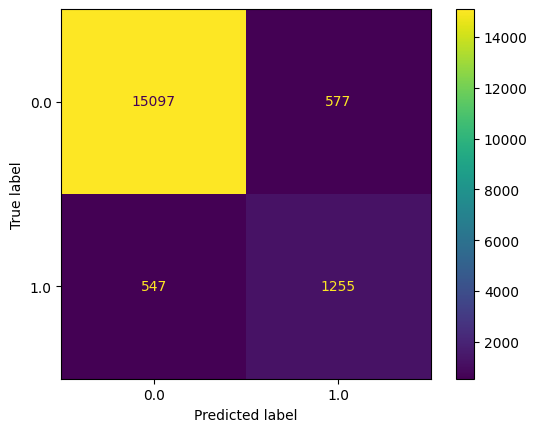

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, train_pred)

## Prueba

In [ ]:
X_test

,loan_amnt,int_rate,annual_inc,dti,delinq_2yrs,fico_range_low,inq_last_6mths,open_acc,pub_rec,revol_bal,...,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,initial_list_status_f,initial_list_status_w,application_type_Individual,application_type_Joint App,hardship_flag_N,hardship_flag_Y
19603,1500.0,8.94,31000.0,8.52,0.0,715.0,0.0,8.0,0.0,1649.0,...,False,False,False,False,True,False,True,False,True,False
2028,16000.0,9.93,84000.0,28.13,1.0,725.0,0.0,7.0,0.0,8301.0,...,False,False,False,False,False,True,True,False,True,False
6425,24000.0,13.11,107282.0,20.94,0.0,715.0,1.0,10.0,0.0,15034.0,...,False,False,False,False,True,False,True,False,True,False
8868,20000.0,12.29,86500.0,20.01,1.0,670.0,0.0,13.0,0.0,38217.0,...,False,False,False,False,False,True,True,False,True,False
14703,16275.0,21.49,45760.0,9.15,0.0,670.0,4.0,17.0,0.0,8476.0,...,False,False,False,False,True,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16673,16800.0,11.47,60000.0,17.52,1.0,690.0,1.0,8.0,0.0,4759.0,...,False,False,False,False,False,True,True,False,True,False
3718,38400.0,16.02,125000.0,27.67,0.0,735.0,3.0,21.0,0.0,24766.0,...,False,False,False,False,True,False,True,False,True,False
13792,17000.0,18.99,37000.0,20.56,0.0,690.0,0.0,12.0,0.0,21355.0,...,False,False,False,False,False,True,True,False,True,False
8571,28000.0,11.53,98976.0,15.18,0.0,685.0,0.0,11.0,0.0,46116.0,...,False,False,False,False,False,True,True,False,True,False


In [ ]:
test_pred = lda.predict(X_test)
print(classification_report(y_test, test_pred))

              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96      6733
         1.0       0.66      0.68      0.67       757

    accuracy                           0.93      7490
   macro avg       0.81      0.82      0.82      7490
weighted avg       0.93      0.93      0.93      7490



In [ ]:
y_test.shape, test_pred.shape

((7490,), (7490,))

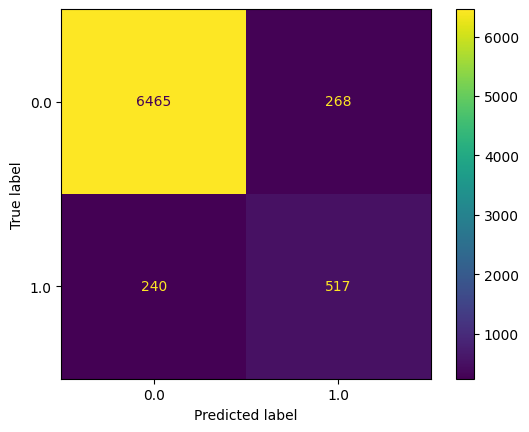

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test, test_pred)

In [ ]:
print(classification_report(y_train, train_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.96      0.96     15674
         1.0       0.69      0.70      0.69      1802

    accuracy                           0.94     17476
   macro avg       0.83      0.83      0.83     17476
weighted avg       0.94      0.94      0.94     17476



Comparación de precisión obtenida en el set de entrenamiento y el set de prueba.

In [ ]:
print(
    lda.score(X_train, y_train),
    lda.score(X_test, y_test)
)

0.9356832227054246 0.9321762349799733


## ¿Cómo afecta cada variable?

In [ ]:
coef_df = pd.DataFrame(lda.coef_[0], X_train.columns, ["coef_"])
print(lda.intercept_)
coef_df

[15.11829494]


,coef_
loan_amnt,0.000040
int_rate,-0.309127
annual_inc,-0.000003
dti,0.009214
delinq_2yrs,-0.154638
...,...
initial_list_status_w,-0.259705
application_type_Individual,0.569422
application_type_Joint App,-0.569422
hardship_flag_N,0.750883


In [ ]:
px.bar(coef_df.reset_index(), 'coef_', 'index')

In [ ]:
X_test.loan_amnt * 10e-6

19603    0.01500
2028     0.16000
6425     0.24000
8868     0.20000
14703    0.16275
          ...   
16673    0.16800
3718     0.38400
13792    0.17000
8571     0.28000
122      0.10000
Name: loan_amnt, Length: 7490, dtype: float64

In [ ]:
y_train[train_pred == 0]

23795    0.0
24969    0.0
3602     0.0
10955    0.0
13729    0.0
        ... 
10208    0.0
9377     0.0
7296     0.0
7298     0.0
17695    0.0
Name: loan_status, Length: 15644, dtype: float64

In [ ]:
np.dot(lda.coef_, X_train.loc[9377, :]) + lda.intercept_

array([-8.678350127125272], dtype=object)

In [ ]:
y_train[train_pred == 1]

16058    1.0
11021    0.0
19026    1.0
20096    0.0
2573     0.0
        ... 
576      0.0
14719    0.0
10148    1.0
4833     1.0
17750    0.0
Name: loan_status, Length: 1832, dtype: float64

In [ ]:
np.dot(lda.coef_, X_train.loc[4833, :]) + lda.intercept_

array([0.6195056144764912], dtype=object)

$$ x_1*\beta_{1} + x_2*\beta_{2} + x_3*\beta_{3} - k = 0$$

# Ejercicios


## Factores

### Condensar niveles

Condensar niveles de factores usualmente es antecedido por un análisis por variable comparando la relación entre cada nivel, la variable de respuesta (en este caso ```loan_status```) y otras covariables. De este modo, niveles que aparentan tener la misma relación con la variable de respuesta pueden juntarse en uno solo; Algunas veces, mejorando el desempeño del modelo y reduciendo la dimensionalidad (y con esto el tiempo de cómputo en algunos casos).

Sin embargo, si se tiene una gran cantidad de factores como covariables y estos a su vez tienen muchos niveles, puede llegar a ser un trabajo arduo que no compense la mejora obtenida en el desempeño del modelo o la rapidez del entrenamiento.

Para este ejercicio, use su intuición en lugar de hacer estas comparaciones. Tampoco es necesario considerar todos los factores, con una cantidad pequeña (por ejemplo, a lo más 3) es suficiente.

1. Condense los niveles de factores que usted considere pueden pertenecer a uno sólo. Puede comenzar con la variable ```home_ownership```, condensando en un nivel llamado ```not_owned``` a todos los niveles que no son ```OWN```.
2. Entrene LDA con estos cambios y compare los resultados obtenidos. ¿Mejoró el modelo?

# Ligas interesantes

- [BASIC LITERACY OF STATISTICS — 3](https://medium.com/@yohoshiva1609/basic-literacy-of-statistics-3-bc9f5a69f116)
- [Sobre la estandarización en variables dummies](https://stats.stackexchange.com/questions/463690/multiple-regression-with-mixed-continuous-categorical-variables-dummy-coding-s)